<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/LSTMAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ======================
# 1. ライブラリ
# ======================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
np.random.seed(42)
torch.manual_seed(42)


Using device: cuda


In [2]:
# ======================
# 2. 合成データ作成（単変量）
#   - 正常: 正弦波 + 小ノイズ
#   - 異常: スパイク、レベルシフトを所々に挿入
# ======================
def make_series(n=5000, anomaly=False):
    t = np.arange(n)
    x = 0.8*np.sin(2*np.pi*t/50) + 0.2*np.sin(2*np.pi*t/10) + 0.1*np.random.randn(n)
    if anomaly:
        # スパイク
        for idx in np.random.choice(np.arange(100, n-100), size=10, replace=False):
            x[idx] += np.random.uniform(2.5, 3.5)
        # レベルシフト（区間オフセット）
        for idx in np.random.choice(np.arange(200, n-200), size=4, replace=False):
            L = np.random.randint(30, 80)
            x[idx:idx+L] += np.random.uniform(0.8, 1.2)
    return x

n_train, n_val, n_test = 6000, 2000, 4000
train_ts = make_series(n_train, anomaly=False)    # 学習は正常のみ
val_ts   = make_series(n_val,   anomaly=False)    # 閾値用も正常
test_ts  = make_series(n_test,  anomaly=True)     # 評価は異常あり

# テスト用の異常ラベルを作る（しきい値なしの「真値」）
# ここでは簡易に「急変」検出による近似的ラベルを付与（教材用）
thr_grad = 1.0
test_labels = (np.abs(np.diff(test_ts, prepend=test_ts[0])) > thr_grad).astype(int)


In [3]:
# ======================
# 3. 窓切り関数（スライディングウィンドウ）
#   入出力形状: [num_windows, seq_len, 1]
# ======================
def to_windows(x, seq_len=64, stride=1):
    X = []
    for i in range(0, len(x)-seq_len+1, stride):
        X.append(x[i:i+seq_len])
    X = np.array(X)[..., None]  # (N, L, 1)
    return X

SEQ_LEN = 64
STRIDE  = 1

X_train = to_windows(train_ts, SEQ_LEN, STRIDE)
X_val   = to_windows(val_ts,   SEQ_LEN, STRIDE)
X_test  = to_windows(test_ts,  SEQ_LEN, STRIDE)

# ラベルを窓に対応づけ（窓内に1つでも異常があれば1、なければ0）
def labels_to_window(labels, seq_len=64, stride=1):
    ws = []
    for i in range(0, len(labels)-seq_len+1, stride):
        ws.append(1 if labels[i:i+seq_len].max()>0 else 0)
    return np.array(ws)

y_test_win = labels_to_window(test_labels, SEQ_LEN, STRIDE)

X_train.shape, X_val.shape, X_test.shape, y_test_win.shape


((5937, 64, 1), (1937, 64, 1), (3937, 64, 1), (3937,))

In [4]:
# ======================
# 4. DataLoader 準備（学習は自己再構成）
# ======================
batch_size = 128
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(X_train, dtype=torch.float32))
val_ds   = TensorDataset(torch.tensor(X_val,   dtype=torch.float32),
                         torch.tensor(X_val,   dtype=torch.float32))
test_ds  = TensorDataset(torch.tensor(X_test,  dtype=torch.float32),
                         torch.tensor(X_test,  dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [5]:
# ======================
# 5. LSTM AutoEncoder 定義
#   Encoder: LSTM -> 最終隠れ状態を潜在に
#   Decoder: LSTM -> 時系列を再構成
# ======================
class LSTMAE(nn.Module):
    def __init__(self, in_dim=1, hid=64, lat=32, num_layers=1):
        super().__init__()
        self.encoder = nn.LSTM(input_size=in_dim, hidden_size=hid, num_layers=num_layers, batch_first=True)
        self.enc_to_lat = nn.Linear(hid, lat)
        self.lat_to_dec = nn.Linear(lat, hid)
        self.decoder = nn.LSTM(input_size=in_dim, hidden_size=hid, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hid, in_dim)

    def forward(self, x):
        # x: (B, L, 1)
        enc_out, (h, c) = self.encoder(x)        # h: (num_layers, B, hid)
        h_last = h[-1]                            # (B, hid)
        z = torch.relu(self.enc_to_lat(h_last))   # (B, lat)
        # decoder初期状態
        dec_h0 = torch.relu(self.lat_to_dec(z)).unsqueeze(0)  # (1, B, hid)
        dec_c0 = torch.zeros_like(dec_h0)
        # デコーダには「ゼロ入力 or ひとつ前の真値」を与える方法がある
        # ここでは真値シーケンス x を条件として与える（Teacher forcing）
        dec_out, _ = self.decoder(x, (dec_h0, dec_c0))        # (B, L, hid)
        x_hat = self.out(dec_out)                             # (B, L, 1)
        return x_hat

model = LSTMAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [6]:
# ======================
# 6. 学習ループ
# ======================
epochs = 20
best_val = np.inf

for ep in range(epochs):
    model.train()
    tr_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        xhat = model(xb)
        loss = criterion(xhat, yb)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xhat = model(xb)
            val_loss += criterion(xhat, yb).item()

    print(f"Epoch {ep+1}/{epochs}  train={tr_loss/len(train_loader):.5f}  val={val_loss/len(val_loader):.5f}")
    best_val = min(best_val, val_loss/len(val_loader))


Epoch 1/20  train=0.19223  val=0.04772
Epoch 2/20  train=0.03790  val=0.03345
Epoch 3/20  train=0.02684  val=0.02076
Epoch 4/20  train=0.01406  val=0.00872
Epoch 5/20  train=0.00588  val=0.00481
Epoch 6/20  train=0.00383  val=0.00349
Epoch 7/20  train=0.00271  val=0.00239
Epoch 8/20  train=0.00179  val=0.00147
Epoch 9/20  train=0.00106  val=0.00082
Epoch 10/20  train=0.00053  val=0.00036
Epoch 11/20  train=0.00027  val=0.00018
Epoch 12/20  train=0.00011  val=0.00008
Epoch 13/20  train=0.00006  val=0.00005
Epoch 14/20  train=0.00005  val=0.00005
Epoch 15/20  train=0.00005  val=0.00004
Epoch 16/20  train=0.00003  val=0.00003
Epoch 17/20  train=0.00003  val=0.00003
Epoch 18/20  train=0.00005  val=0.00003
Epoch 19/20  train=0.00002  val=0.00002
Epoch 20/20  train=0.00002  val=0.00002


In [7]:
# ======================
# 7. 再構成誤差（窓ごと & 時点ごと）
#   - 窓スコア: MSE を (B,L,1) -> (B,) に平均
#   - 時点スコア: 全窓の同じ時点の誤差を後で集約して系列へ戻す
# ======================
def window_scores(dloader):
    model.eval()
    all_scores = []
    all_recon = []
    with torch.no_grad():
        for xb,_ in dloader:
            xb = xb.to(device)
            xhat = model(xb)
            # 窓MSE
            mse = torch.mean((xb - xhat)**2, dim=(1,2))  # (B,)
            all_scores.append(mse.cpu().numpy())
            all_recon.append(xhat.cpu().numpy())
    return np.concatenate(all_scores), np.concatenate(all_recon)

val_scores, _  = window_scores(val_loader)
test_scores, R = window_scores(test_loader)

# 閾値（正常95パーセンタイル）
thr = np.percentile(val_scores, 95)
print("threshold (val 95%):", float(thr))

# 窓レベルの判定
test_pred_win = (test_scores > thr).astype(int)


threshold (val 95%): 4.4264608732191846e-05


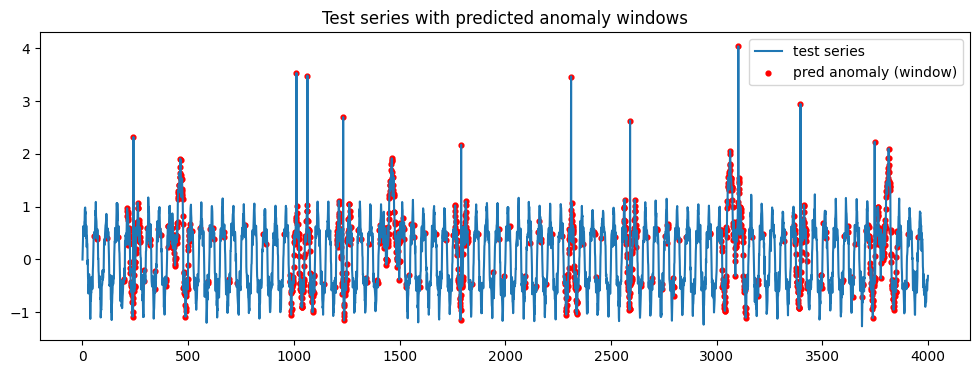

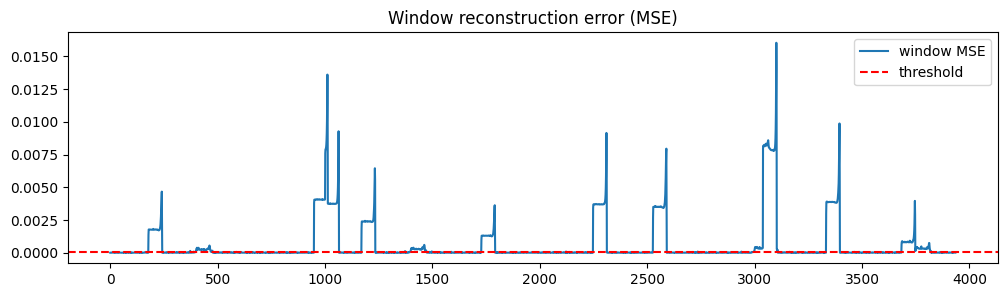

In [8]:
# ======================
# 8. 可視化（時系列とスコア）
# ======================
plt.figure(figsize=(12,4))
plt.plot(test_ts, label="test series")
# 異常予測された窓の中心を赤点で描く
centers = np.arange(SEQ_LEN//2, SEQ_LEN//2 + len(test_pred_win))
plt.scatter(centers[test_pred_win==1], test_ts[centers[test_pred_win==1]], c='r', s=12, label="pred anomaly (window)")
plt.title("Test series with predicted anomaly windows")
plt.legend(); plt.show()

plt.figure(figsize=(12,3))
plt.plot(test_scores, label="window MSE")
plt.axhline(thr, color="r", linestyle="--", label="threshold")
plt.title("Window reconstruction error (MSE)")
plt.legend(); plt.show()


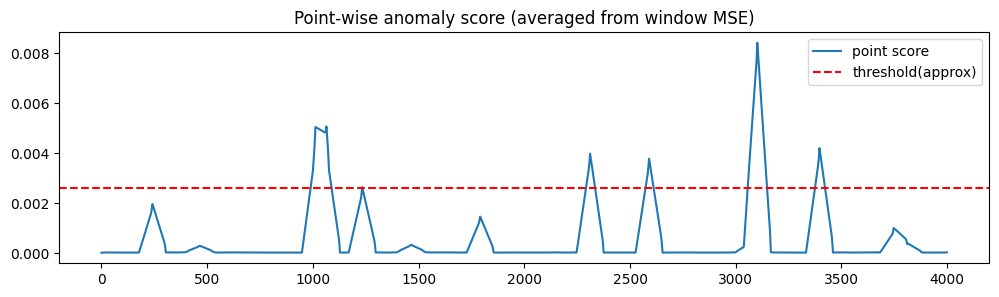

In [9]:
# ======================
# 9. （任意）系列スコア化：窓誤差を時点へ配布して平均
#   各時点にカバーする窓の誤差平均を割り当て、点ごとの異常スコア可視化
# ======================
point_scores = np.zeros(len(test_ts))
counts = np.zeros(len(test_ts))
for i in range(len(test_scores)):
    point_scores[i:i+SEQ_LEN] += test_scores[i]
    counts[i:i+SEQ_LEN] += 1
mask = counts > 0
point_scores[mask] /= counts[mask]

pt_thr = np.percentile(point_scores[:len(val_ts)], 95)  # 粗い近似（本来はvalで要計算）
plt.figure(figsize=(12,3))
plt.plot(point_scores, label="point score")
plt.axhline(pt_thr, color="r", linestyle="--", label="threshold(approx)")
plt.title("Point-wise anomaly score (averaged from window MSE)")
plt.legend(); plt.show()


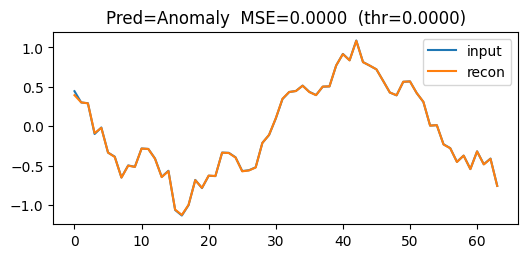

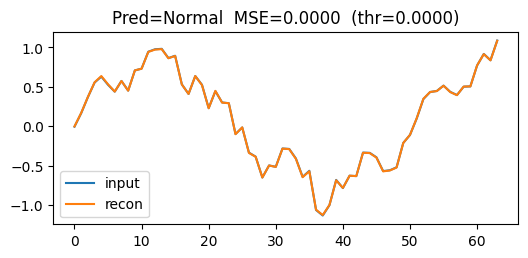

In [10]:
# ======================
# 10. 誤検知/見逃しの具体例を確認（窓を数枚プロット）
# ======================
def plot_window_example(idx, title=""):
    x = X_test[idx,:,0]
    # 再構成（すでに R に格納）
    xhat = R[idx,:,0]
    plt.figure(figsize=(6,2.5))
    plt.plot(x,  label="input")
    plt.plot(xhat, label="recon")
    color = "red" if test_scores[idx] > thr else "green"
    plt.title(f"{title}  MSE={test_scores[idx]:.4f}  (thr={thr:.4f})")
    plt.legend()
    plt.show()

# 異常と判定された窓の例 / 正常と判定された窓の例
anom_idx = np.where(test_pred_win==1)[0]
norm_idx = np.where(test_pred_win==0)[0]
if len(anom_idx)>0: plot_window_example(anom_idx[0], "Pred=Anomaly")
if len(norm_idx)>0: plot_window_example(norm_idx[0], "Pred=Normal")
